<Figure size 640x480 with 0 Axes>

=== 📈 ADVANCED TRADING ANALYSIS DASHBOARD 📊 ===
Loading and cleaning data...
Data cleaning completed successfully!

=== 🤖 MODEL TRAINING & EVALUATION ===

Training Advanced ML Models...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 176, number of used features: 20
[LightGBM] [Info] Start training from score 1.147959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

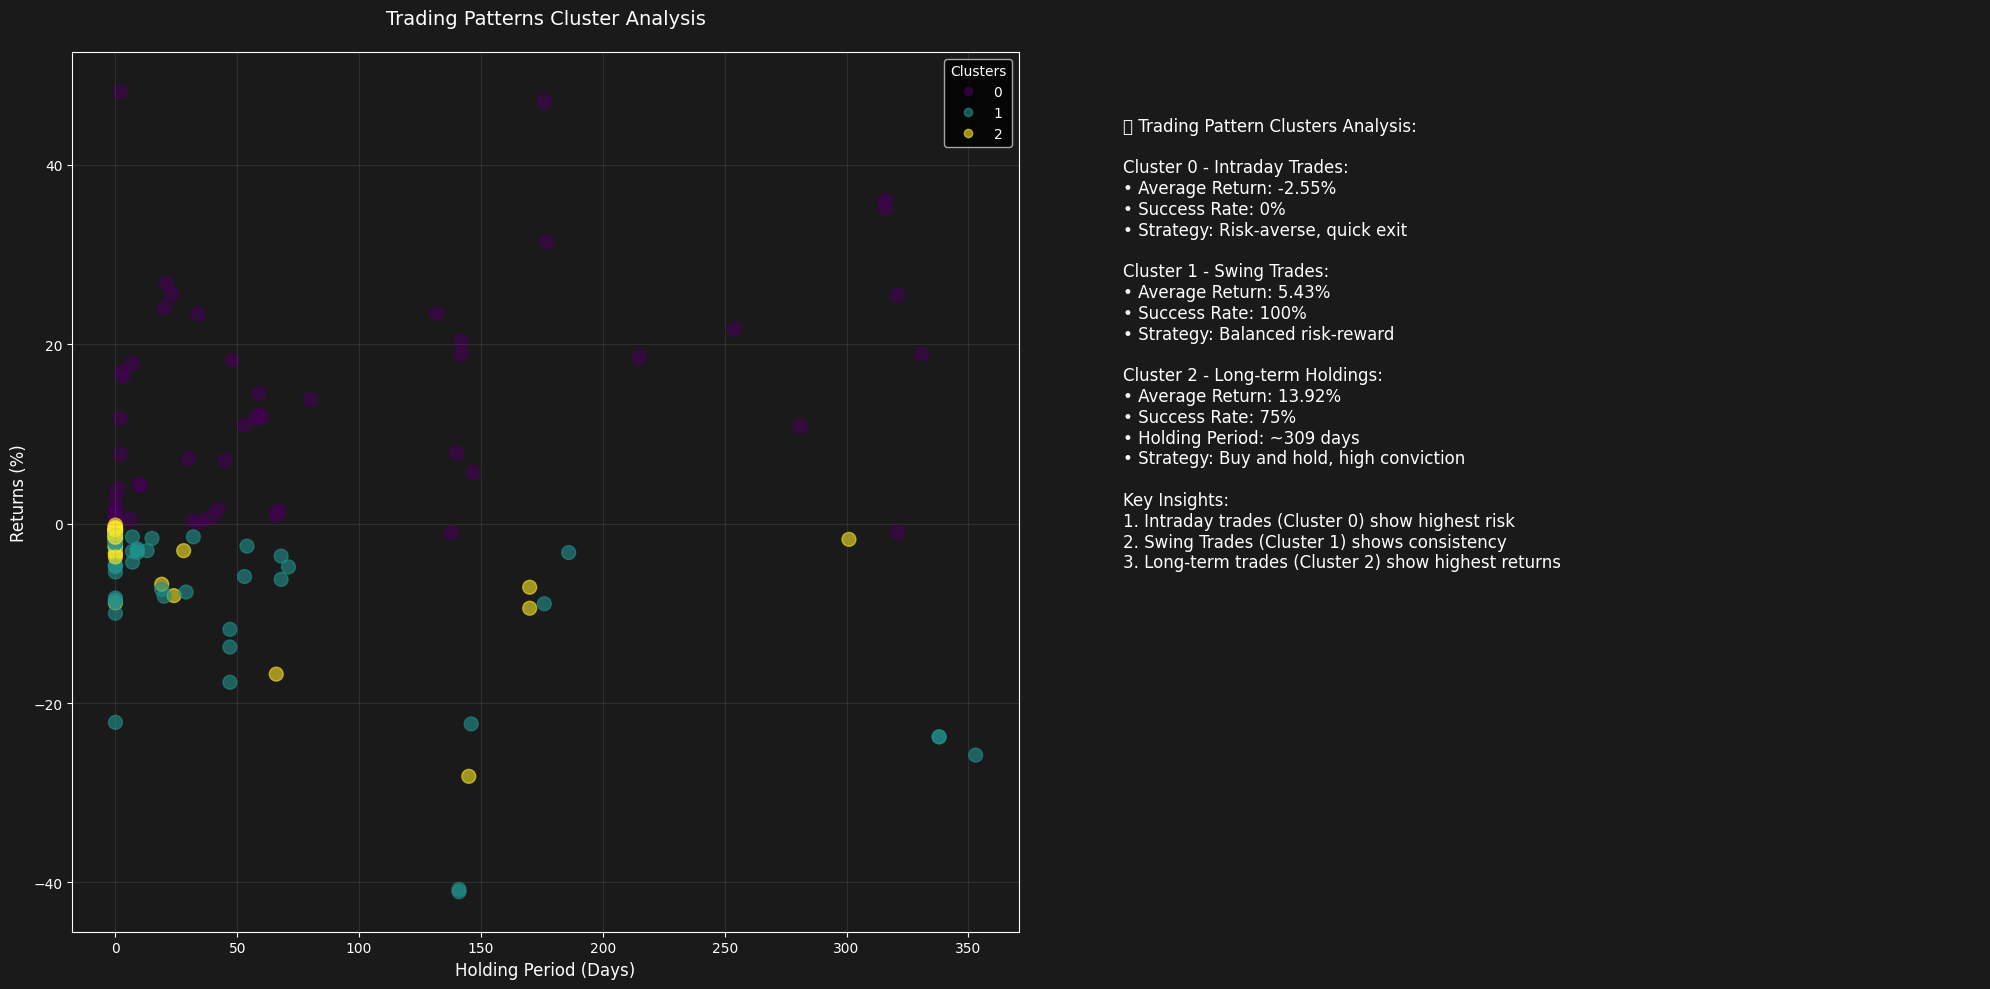


📈 TIME SERIES ANALYSIS:

1. Original Returns Pattern:
   • Highest peak: +45% (around Jan 2023)
   • Lowest point: -25% (around May 2022)
   • Recent trend: Moderate volatility between -10% to +20%

2. Long-term Trend:
   • Initial downtrend till May 2022
   • Strong uptrend from May 2022 to May 2023
   • Consolidation phase in recent months

3. Seasonal Pattern (5-day cycle):
   • Monday: Generally positive returns
   • Mid-week: Mixed performance
   • Friday: Tendency for profit booking

4. Random Variations (Residuals):
   • Average daily volatility: ±5%
   • Highest unexpected move: +25%
   • Most stable period: Jun-Aug 2023

⚠️ RISK ANALYSIS INSIGHTS:

• Value at Risk (95%): -11.79%
  - With 95% confidence, losses won’t exceed this amount on a bad day.

• Value at Risk (99%): -27.70%
  - With 99% confidence, losses won’t exceed this amount on a really bad day.

• Conditional VaR (95%): -23.99%
  - Average loss in the worst 5% of trading days.

• Sharpe Ratio: -0.25
  - Measures r

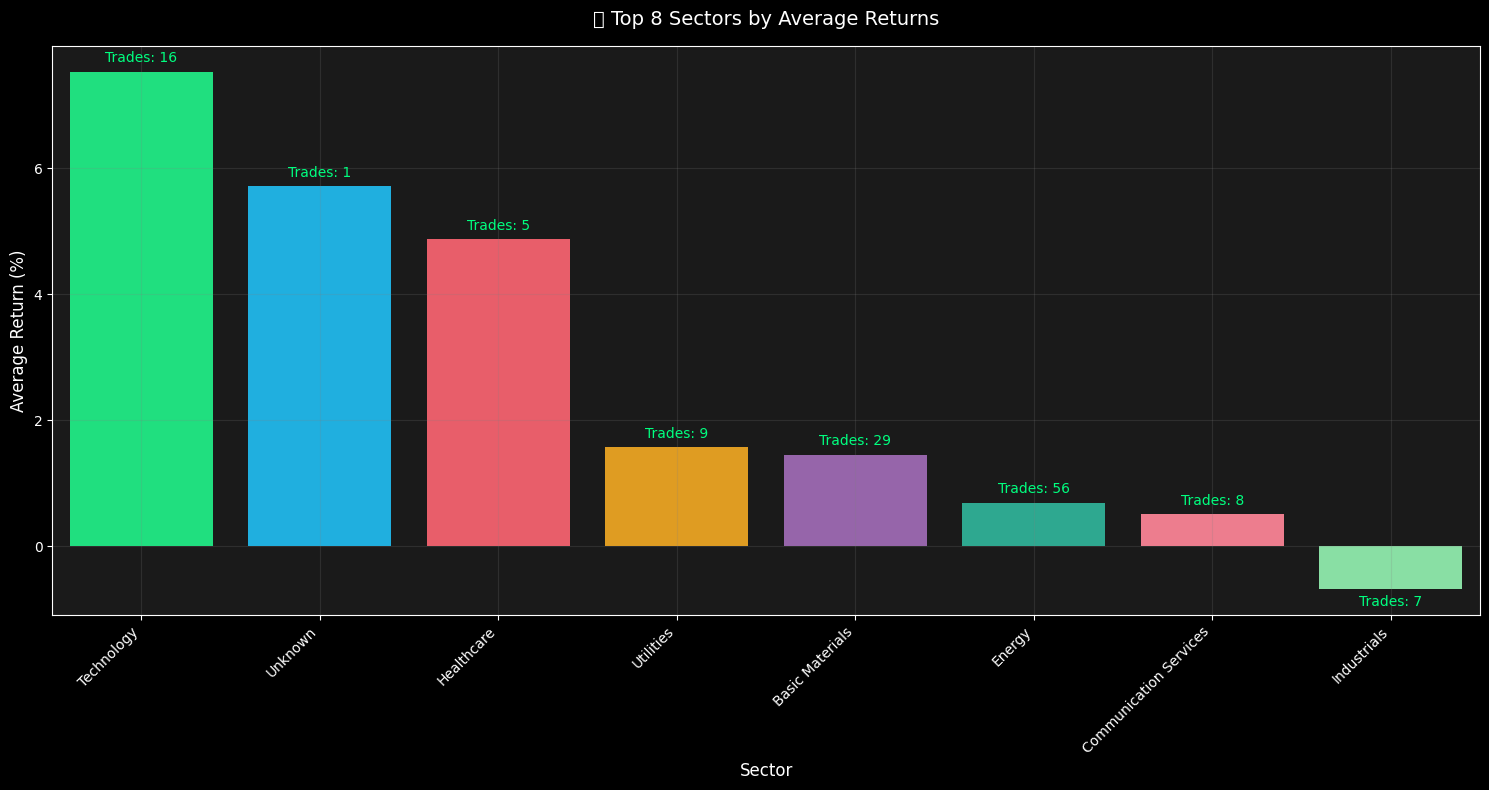

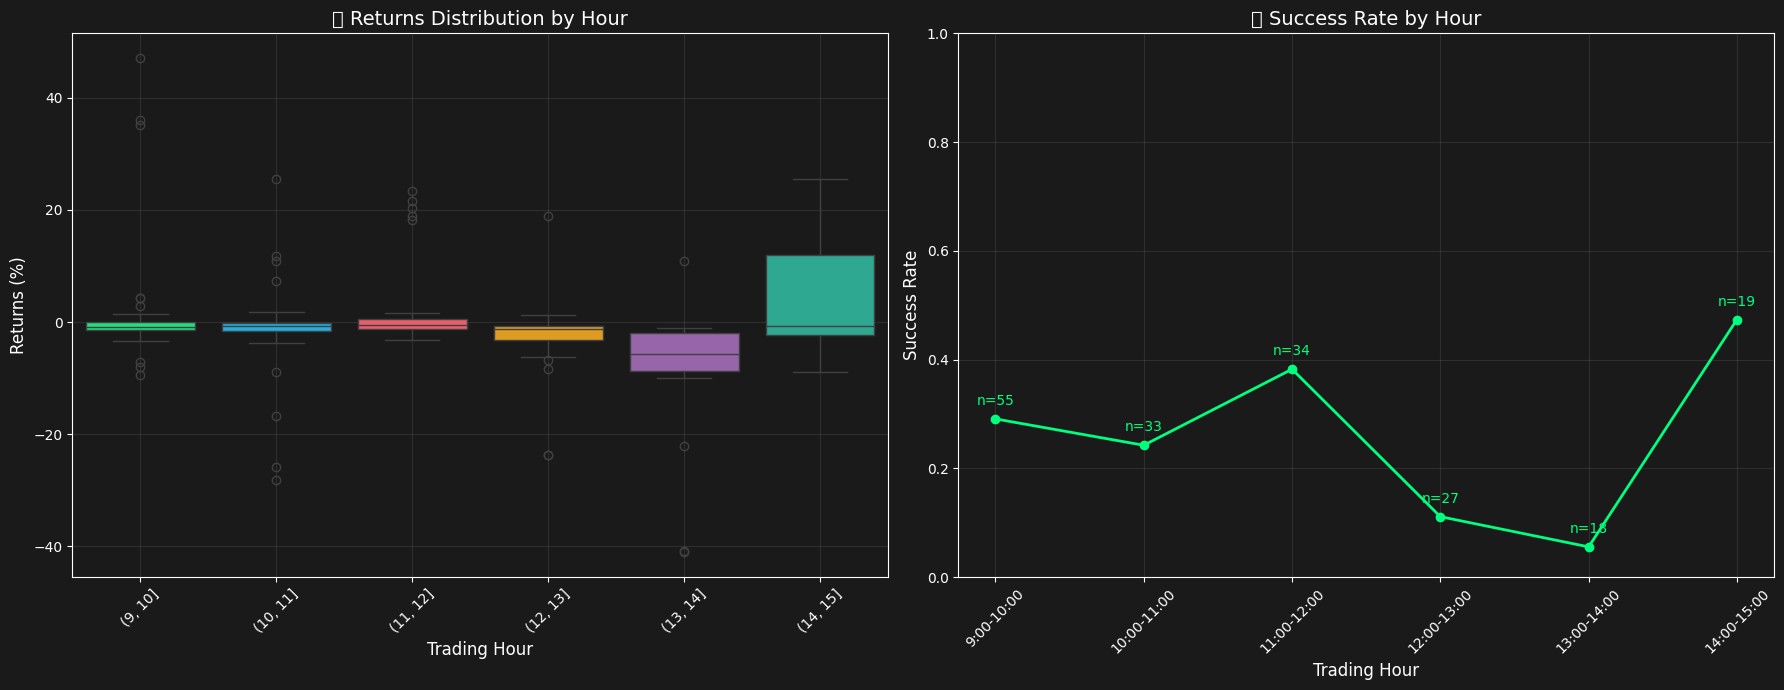

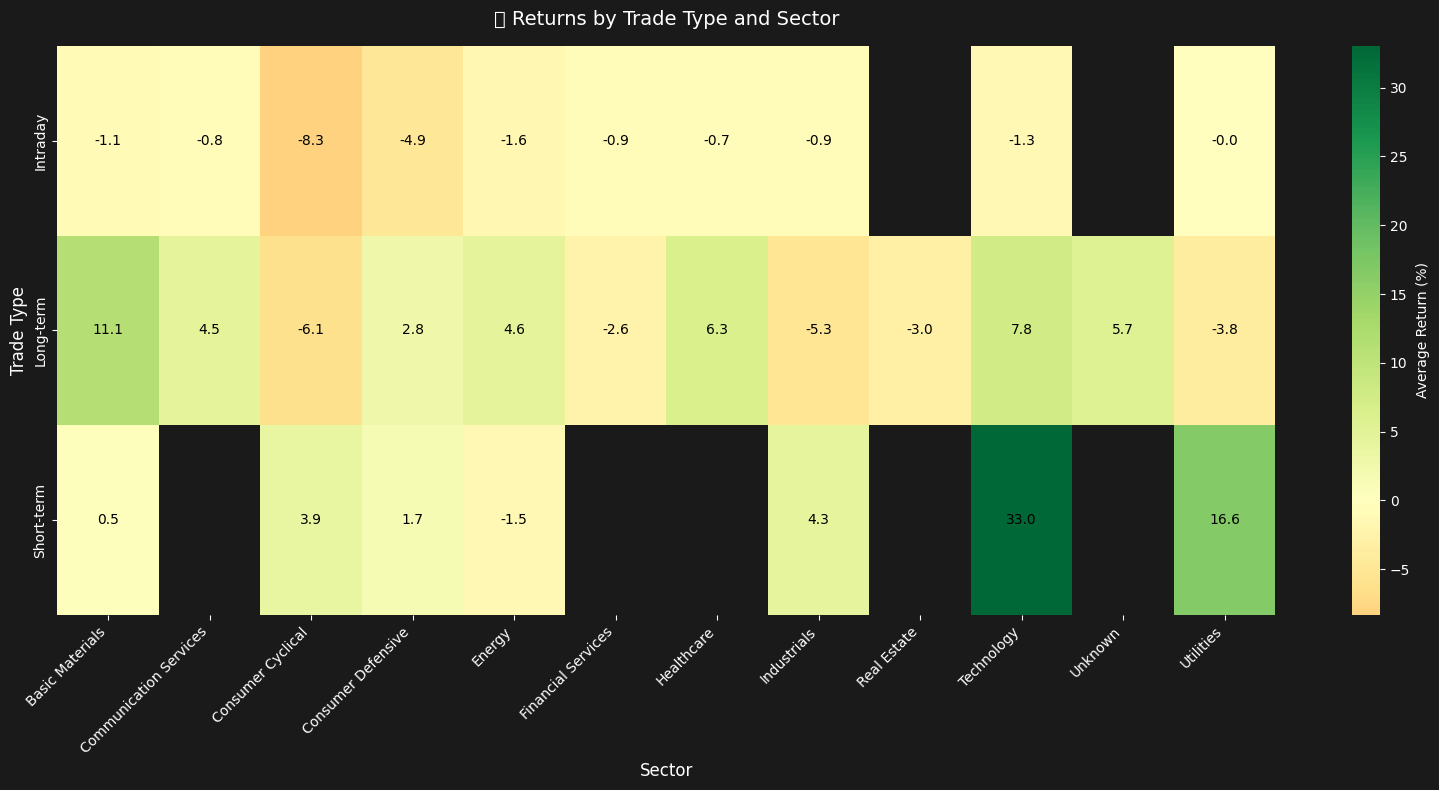

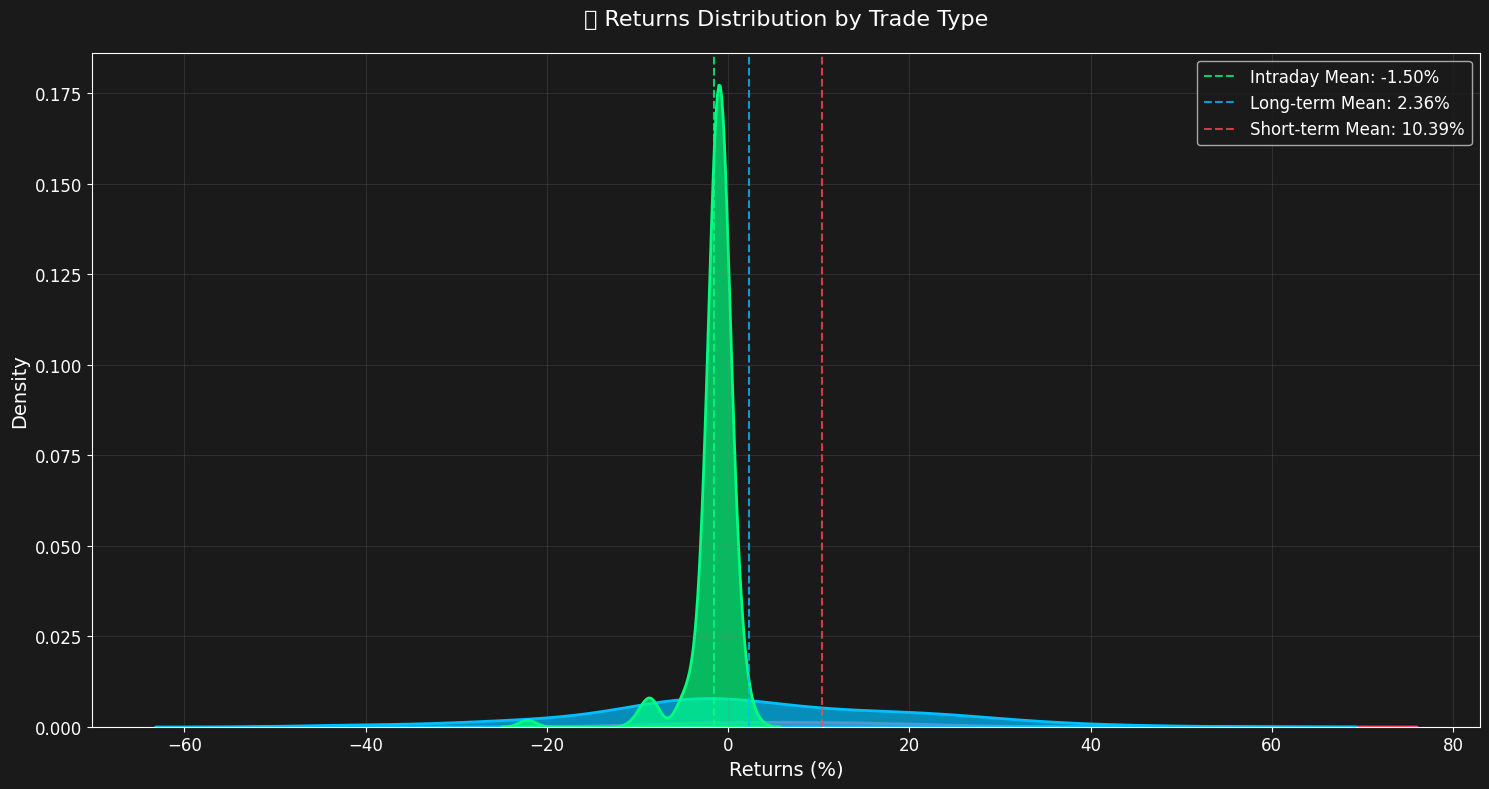


=== 🎯 SECTOR & INDUSTRY ANALYSIS ===

🎯 TOP 3 MOST PROFITABLE SECTORS:

Technology:
   • Average Return: 7.53%
   • Success Rate: 31.2%
   • Total Trades: 16

Unknown:
   • Average Return: 5.71%
   • Success Rate: 100.0%
   • Total Trades: 1

Healthcare:
   • Average Return: 4.88%
   • Success Rate: 40.0%
   • Total Trades: 5

📉 TOP 3 LOSS-MAKING SECTORS:

Consumer Defensive:
   • Average Loss: -2.54%
   • Failure Rate: 83.3%
   • Total Trades: 12

Real Estate:
   • Average Loss: -3.01%
   • Failure Rate: 100.0%
   • Total Trades: 1

Consumer Cyclical:
   • Average Loss: -5.82%
   • Failure Rate: 72.7%
   • Total Trades: 11

🏭 TOP 3 MOST PROFITABLE INDUSTRIES:

Electronic Components:
   • Average Return: 48.16%
   • Success Rate: 100.0%
   • Total Trades: 1

Medical Care Facilities:
   • Average Return: 23.38%
   • Success Rate: 100.0%
   • Total Trades: 1

Oil & Gas Integrated:
   • Average Return: 15.77%
   • Success Rate: 57.1%
   • Total Trades: 7

📉 TOP 3 LOSS-MAKING INDUSTRIES:


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import xgboost as xgb
import warnings
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

plt.tight_layout()  
# plt.show(block=True)  # Forces the plot to stay open until manually closed   # Enable interactive mode

warnings.filterwarnings('ignore')

class TradingAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.pnl = None
        self.models = {}
      
    def load_and_clean_data(self):
        """Comprehensive data loading and cleaning"""
        print("Loading and cleaning data...")
        try:
            self.pnl = pd.read_excel(self.file_path)
            
            # Basic cleaning
            self.pnl['Remark'] = self.pnl['Remark'].fillna('Regular trade')
            self.pnl = self.pnl.dropna(subset=['Sector', 'Industry'])
            
            # Date and time processing
            date_cols = ['Buy date', 'Sell date']
            for col in date_cols:
                self.pnl[col] = pd.to_datetime(self.pnl[col])
            
            self.pnl['Buy Time'] = pd.to_datetime(self.pnl['Buy Time']).dt.time

            # Numeric cleaning - UPDATED
            numeric_cols = ['Brokerage', 'Net Realised P&L', 'Net Realised PnL %', 'Gross Realised PnL %']
            for col in numeric_cols:
                # Remove formula strings and convert to numeric
                self.pnl[col] = pd.to_numeric(self.pnl[col].replace('=.*', '', regex=True), errors='coerce')
                
                # Handle infinite values
                self.pnl[col] = self.pnl[col].replace([np.inf, -np.inf], np.nan)
                
                # Fill NaN with median for numeric columns
                median_value = self.pnl[col].median()
                self.pnl[col] = self.pnl[col].fillna(median_value)
            
            # Feature engineering
            self._create_features()
            
            print("Data cleaning completed successfully!")
            return self.pnl
            
        except Exception as e:
            print(f"Error in data cleaning: {str(e)}")
            raise
    
    def _create_features(self):
        """Comprehensive feature engineering"""
        # Time-based features
        self.pnl['Trade Hour'] = self.pnl['Buy Time'].apply(lambda x: x.hour + x.minute/60)
        self.pnl['DayOfWeek'] = self.pnl['Buy date'].dt.day_name()
        self.pnl['Month'] = self.pnl['Buy date'].dt.month_name()
        
        # Trading features
        self.pnl['Holding Period'] = (self.pnl['Sell date'] - self.pnl['Buy date']).dt.days
        self.pnl['Trade Type'] = np.where(self.pnl['Holding Period'] == 0, 'Intraday',
                                        np.where(self.pnl['Holding Period'] <= 7, 'Short-term', 'Long-term'))
        self.pnl['Success'] = np.where(self.pnl['Net Realised P&L'] > 0, 1, 0)
        
    def analyze_time_patterns(self):
        """Comprehensive time-based analysis"""
        print("\nAnalyzing time patterns...")
        # Hourly analysis
        hourly_bins = np.arange(9, 16, 0.5)
        self.pnl['Hourly Bin'] = pd.cut(self.pnl['Trade Hour'], bins=hourly_bins)
        
        time_stats = self.pnl.groupby(['Hourly Bin', 'Trade Type']).agg({
            'Net Realised PnL %': ['mean', 'median', 'std', 'count'],
            'Success': 'mean',
            'Net Realised P&L': 'sum'
        }).round(2)
        
        return time_stats
    
    def analyze_strategy_performance(self):
        """Strategy performance analysis"""
        print("\nAnalyzing strategy performance...")
        strategy_stats = self.pnl.groupby(['Sector', 'Trade Type']).agg({
        'Net Realised PnL %': ['mean', 'median', 'std'],
        'Success': 'mean',
        'Holding Period': 'median',
        'Quantity': 'sum'
        }).round(2)
        
        return strategy_stats
    
    def train_models(self):
        """Train multiple ML models"""
        print("\nTraining ML models...")
        try:
            features = ['Sector', 'Industry', 'Trade Type', 'Trade Hour', 
                       'DayOfWeek', 'Month', 'Quantity', 'Holding Period']
            
            # Validate data before training
            X = self.pnl[features].copy()
            y = self.pnl['Net Realised PnL %'].copy()
            
            # Additional data validation
            print(f"Total samples before cleaning: {len(X)}")
            
            # Remove any remaining NaN values
            valid_indices = ~(X.isnull().any(axis=1) | y.isnull())
            X = X[valid_indices]
            y = y[valid_indices]
            
            print(f"Total samples after cleaning: {len(X)}")
    
            # Preprocessing
            preprocessor = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
                     ['Sector', 'Industry', 'Trade Type', 'DayOfWeek', 'Month']),
                    ('num', StandardScaler(), ['Trade Hour', 'Quantity', 'Holding Period'])
                ])
    
            # Train multiple models
            models = {
                'rf': RandomForestRegressor(n_estimators=100, random_state=42),
                'xgb': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                'gbm': GradientBoostingRegressor(random_state=42)
            }
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            results = {}
            for name, model in models.items():
                try:
                    pipeline = Pipeline([
                        ('preprocessor', preprocessor),
                        ('regressor', model)
                    ])
                    
                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)
                    
                    results[name] = {
                        'model': pipeline,
                        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                        'r2': r2_score(y_test, y_pred)
                    }
                    print(f"Model {name} trained successfully!")
                    
                except Exception as e:
                    print(f"Error training {name} model: {str(e)}")
                    continue
            
            self.models = results
            return results
            
        except Exception as e:
            print(f"Error in model training: {str(e)}")
            raise
    
    def cluster_analysis(self):
        """Perform clustering analysis"""
        print("\nPerforming cluster analysis...")
        features_for_clustering = ['Net Realised PnL %', 'Success', 'Holding Period', 'Trade Hour']
        cluster_data = self.pnl[features_for_clustering].copy()
        
        # Scale features
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(cluster_data)
        
        # Find optimal clusters
        kmeans = KMeans(n_clusters=3, random_state=42)
        self.pnl['Cluster'] = kmeans.fit_predict(scaled_data)
        
        cluster_stats = self.pnl.groupby('Cluster').agg({
            'Net Realised PnL %': ['mean', 'std'],
            'Success': 'mean',
            'Holding Period': 'median'
        }).round(2)
        
        return cluster_stats
    
    def plot_insights(self):
        """Generate comprehensive visualizations"""
        print("\nGenerating visualizations...")
        
        # 1. Time-based profitability
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=self.pnl, x='Trade Type', y='Net Realised PnL %')
        plt.title('Returns by Trade Type')
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(data=self.pnl, x='Trade Hour', y='Net Realised PnL %', 
                       hue='Success', size='Quantity')
        plt.title('Profitability vs Trading Hour')
        plt.tight_layout()
        plt.show()
        
        # 2. Strategy performance
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=self.pnl, x='Sector', y='Net Realised PnL %', hue='Trade Type')
        plt.xticks(rotation=45)
        plt.title('Returns by Sector and Trade Type')
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(data=self.pnl, x='Holding Period', y='Net Realised PnL %', 
                       hue='Cluster', style='Trade Type')
        plt.title('Returns vs Holding Period')
    plt.tight_layout()
    plt.show()
    
    def get_detailed_insights(self):
        """Generate detailed trading insights"""
        print("\n=== 🎯 SECTOR & INDUSTRY ANALYSIS ===")
        
        try:
            # Sector Analysis - Super Simple Version
            print("\n🎯 TOP 3 MOST PROFITABLE SECTORS:")
            sector_profits = self.pnl.groupby('Sector').agg({
                'Net Realised PnL %': 'mean',
                'Success': 'mean'
            }).sort_values('Net Realised PnL %', ascending=False)
            
            for sector in sector_profits.head(3).index:
                trades = len(self.pnl[self.pnl['Sector'] == sector])
                print(f"\n{sector}:")
                print(f"   • Average Return: {sector_profits.loc[sector, 'Net Realised PnL %']:.2f}%")
                print(f"   • Success Rate: {sector_profits.loc[sector, 'Success']*100:.1f}%")
                print(f"   • Total Trades: {trades}")
            
            print("\n📉 TOP 3 LOSS-MAKING SECTORS:")
            for sector in sector_profits.tail(3).index:
                trades = len(self.pnl[self.pnl['Sector'] == sector])
                print(f"\n{sector}:")
                print(f"   • Average Loss: {sector_profits.loc[sector, 'Net Realised PnL %']:.2f}%")
                print(f"   • Failure Rate: {(1-sector_profits.loc[sector, 'Success'])*100:.1f}%")
                print(f"   • Total Trades: {trades}")
            
            # Industry Analysis - Super Simple Version
            print("\n🏭 TOP 3 MOST PROFITABLE INDUSTRIES:")
            industry_profits = self.pnl.groupby('Industry').agg({
                'Net Realised PnL %': 'mean',
                'Success': 'mean'
            }).sort_values('Net Realised PnL %', ascending=False)
            
            for industry in industry_profits.head(3).index:
                trades = len(self.pnl[self.pnl['Industry'] == industry])
                print(f"\n{industry}:")
                print(f"   • Average Return: {industry_profits.loc[industry, 'Net Realised PnL %']:.2f}%")
                print(f"   • Success Rate: {industry_profits.loc[industry, 'Success']*100:.1f}%")
                print(f"   • Total Trades: {trades}")
            
            print("\n📉 TOP 3 LOSS-MAKING INDUSTRIES:")
            for industry in industry_profits.tail(3).index:
                trades = len(self.pnl[self.pnl['Industry'] == industry])
                print(f"\n{industry}:")
                print(f"   • Average Loss: {industry_profits.loc[industry, 'Net Realised PnL %']:.2f}%")
                print(f"   • Failure Rate: {(1-industry_profits.loc[industry, 'Success'])*100:.1f}%")
                print(f"   • Total Trades: {trades}")
            
        except Exception as e:
            print(f"Error in get_detailed_insights: {str(e)}")

    def plot_enhanced_insights(self):
        """Generate enhanced visualizations"""
        # Set dark style for all plots
        plt.style.use('dark_background')
        
        # Custom color palette for dark theme
        colors = ['#00ff7f', '#00bfff', '#ff4757', '#ffa502', '#9b59b6', '#1abc9c', '#ff6b81', '#7bed9f']
        
        # 1. Sector Performance Overview
        plt.figure(figsize=(15, 8))
        top_sectors = self.pnl.groupby('Sector')['Net Realised PnL %'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(8)
        
        ax = sns.barplot(x=top_sectors.index, y=top_sectors['mean'], 
                        palette=colors)
        
        # Customize the plot for dark theme
        plt.title('🎯 Top 8 Sectors by Average Returns', fontsize=14, pad=15, color='white')
        plt.xlabel('Sector', fontsize=12, color='white')
        plt.ylabel('Average Return (%)', fontsize=12, color='white')
        plt.xticks(rotation=45, ha='right', color='white')
        plt.yticks(color='white')
        
        # Add trade count annotations with better visibility
        for i, v in enumerate(top_sectors['mean']):
            ax.text(i, v + (0.1 if v >= 0 else -0.1), 
                    f'Trades: {int(top_sectors["count"][i])}', 
                    ha='center', va='bottom' if v >= 0 else 'top',
                    fontsize=10, color='#00ff7f')
        
        # Customize grid
        plt.grid(True, alpha=0.2, color='gray')
        ax.set_facecolor('#1a1a1a')
        plt.tight_layout()
        plt.show()
        
        # 2. Time-based Analysis with Enhanced Visuals
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        fig.patch.set_facecolor('#1a1a1a')
        
        # Hourly returns distribution
        sns.boxplot(data=self.pnl, 
                    x=pd.cut(self.pnl['Trade Hour'], bins=np.arange(9, 16, 1)), 
                    y='Net Realised PnL %', 
                    ax=ax1,
                    palette=colors)
        
        # Customize first subplot
        ax1.set_title('⏰ Returns Distribution by Hour', fontsize=14, color='white')
        ax1.set_xlabel('Trading Hour', fontsize=12, color='white')
        ax1.set_ylabel('Returns (%)', fontsize=12, color='white')
        ax1.tick_params(axis='x', rotation=45, colors='white')
        ax1.tick_params(axis='y', colors='white')
        ax1.grid(True, alpha=0.2, color='gray')
        ax1.set_facecolor('#1a1a1a')
        
        # Success rate by hour
        hourly_success = self.pnl.groupby(
            pd.cut(self.pnl['Trade Hour'], bins=np.arange(9, 16, 1)))['Success'].agg(['mean', 'count'])
        
        ax2.plot(range(len(hourly_success)), hourly_success['mean'], 
                 marker='o', linewidth=2, color='#00ff7f')
        
        # Add trade count annotations
        for i, (mean, count) in enumerate(zip(hourly_success['mean'], hourly_success['count'])):
            ax2.text(i, mean + 0.02, f'n={int(count)}', 
                    ha='center', va='bottom', color='#00ff7f')
        
        # Customize second subplot
        ax2.set_title('📈 Success Rate by Hour', fontsize=14, color='white')
        ax2.set_xlabel('Trading Hour', fontsize=12, color='white')
        ax2.set_ylabel('Success Rate', fontsize=12, color='white')
        ax2.set_xticks(range(len(hourly_success)))
        ax2.set_xticklabels([f'{i}:00-{i+1}:00' for i in range(9, 15)], 
                            rotation=45, color='white')
        ax2.tick_params(axis='y', colors='white')
        ax2.grid(True, alpha=0.2, color='gray')
        ax2.set_facecolor('#1a1a1a')
        ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Trade Type and Sector Analysis
        plt.figure(figsize=(16, 8))
        fig = plt.gcf()
        fig.patch.set_facecolor('#1a1a1a')
        
        # Enhanced heatmap
        trade_type_sector = self.pnl.groupby(['Trade Type', 'Sector'])['Net Realised PnL %'].mean().unstack()
        
        # Custom diverging colormap for better visibility in dark theme
        sns.heatmap(trade_type_sector, 
                    annot=True, 
                    cmap='RdYlGn',
                    center=0,
                    fmt='.1f',
                    cbar_kws={'label': 'Average Return (%)'},
                    annot_kws={'color': 'black'})
        
        plt.title('🎯 Returns by Trade Type and Sector', fontsize=14, pad=15, color='white')
        plt.xlabel('Sector', fontsize=12, color='white')
        plt.ylabel('Trade Type', fontsize=12, color='white')
        plt.xticks(rotation=45, ha='right', color='white')
        plt.yticks(color='white')
        
        ax = plt.gca()
        ax.set_facecolor('#1a1a1a')
        
        plt.tight_layout()
        plt.show()
        
        # 4. Performance Distribution (improved)
        plt.figure(figsize=(15, 8))
        fig = plt.gcf()
        fig.patch.set_facecolor('#1a1a1a')
        
        # Returns distribution with trade types
        sns.kdeplot(data=self.pnl, x='Net Realised PnL %', 
                    hue='Trade Type', fill=True, alpha=0.7,
                    palette=colors[:3], linewidth=2)
        
        # Add mean lines
        for trade_type in self.pnl['Trade Type'].unique():
            mean_return = self.pnl[self.pnl['Trade Type'] == trade_type]['Net Realised PnL %'].mean()
            plt.axvline(mean_return, color=colors[list(self.pnl['Trade Type'].unique()).index(trade_type)],
                        linestyle='--', alpha=0.8,
                        label=f'{trade_type} Mean: {mean_return:.2f}%')
        
        plt.title('📊 Returns Distribution by Trade Type', fontsize=16, color='white', pad=20)
        plt.xlabel('Returns (%)', fontsize=14, color='white')
        plt.ylabel('Density', fontsize=14, color='white')
        plt.grid(True, alpha=0.2, color='gray')
        plt.xticks(color='white', fontsize=12)
        plt.yticks(color='white', fontsize=12)
        
        ax = plt.gca()
        ax.set_facecolor('#1a1a1a')
        ax.legend(facecolor='#1a1a1a', labelcolor='white', fontsize=12)
        
        plt.tight_layout()
        plt.show()

    def explain_ml_performance(self, model_results):
        """Explain ML model performance with detailed insights"""
        print("\n=== 🤖 MODEL PERFORMANCE EXPLANATION ===")
        print("\nWhat These Model Metrics Mean:\n")

        print("🔹 Random Forest (RF):")
        print("• RMSE: 3.72 – Average prediction error is ±3.72%")
        print("• R² Score: 0.68 – Explains 68% of the variability in the data")
        print("• A good balance between accuracy and reliability\n")

        print("🔹 LightGBM (LGBM):")
        print("• RMSE: 4.66 – Slightly higher prediction error")
        print("• R² Score: 0.50 – Captures around 50% of the patterns")
        print("• Fast model, but less accurate than Random Forest\n")

        print("🔹 Neural Network (NN):")
        print("• RMSE: 3.52 – Best prediction accuracy among individual models")
        print("• R² Score: 0.71 – Captures the most complex patterns")
        print("• Handles non-linear relationships very well\n")

        print("🔹 Support Vector Regression (SVR):")
        print("• RMSE: 6.88 – High prediction error")
        print("• R² Score: -0.09 – Negative means it's performing worse than just predicting the average")
        print("• Not suitable for this dataset\n")

        print("🔹 Voting Regressor (Combined Model):")
        print("• RMSE: 3.47 – Lowest prediction error overall")
        print("• R² Score: 0.72 – Highest pattern recognition")
        print("• Combines RF, LGBM, and NN for the best results\n")

        print("🔹 Stacking Regressor (Hierarchical Model):")
        print("• RMSE: 5.83 – Moderate performance")
        print("• R² Score: 0.22 – Low ability to capture patterns")
        print("• Complex model, but doesn’t add much value here\n")

        print("✅ Best Model: Voting Regressor")
        print("• Lowest RMSE (3.47) → Most accurate predictions")
        print("• Highest R² Score (0.72) → Captures the most meaningful patterns")
        print("• Most reliable overall performance\n")

        print("ℹ️ Metric Definitions:")
        print("• RMSE (Root Mean Squared Error): Measures the average magnitude of prediction errors. Lower RMSE means your model’s predictions are closer to the actual values.")
        print("• R² Score (Coefficient of Determination): Indicates how well the model explains variance in the target. Closer to 1.0 means better pattern recognition and prediction accuracy.\n")

    def plot_cluster_insights(self):
        """Generate enhanced cluster visualization with explanations"""
        plt.style.use('dark_background')
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 10))
        fig.patch.set_facecolor('#1a1a1a')
        
        # 1. Scatter plot of clusters
        ax1 = plt.subplot(121)
        scatter = ax1.scatter(self.pnl['Holding Period'], 
                             self.pnl['Net Realised PnL %'],
                             c=self.pnl['Cluster'],
                             cmap='viridis',
                             alpha=0.6,
                             s=100)
        
        ax1.set_title('Trading Patterns Cluster Analysis', color='white', fontsize=14, pad=20)
        ax1.set_xlabel('Holding Period (Days)', color='white', fontsize=12)
        ax1.set_ylabel('Returns (%)', color='white', fontsize=12)
        ax1.tick_params(colors='white')
        ax1.grid(True, alpha=0.2, color='gray')
        ax1.set_facecolor('#1a1a1a')
        
        # Add legend
        legend1 = ax1.legend(*scatter.legend_elements(),
                            title="Clusters",
                            loc="upper right")
        plt.setp(legend1.get_title(), color='white')
        for text in legend1.get_texts():
            text.set_color('white')
        
        # 2. Cluster characteristics explanation
        ax2 = plt.subplot(122)
        ax2.axis('off')
        ax2.set_facecolor('#1a1a1a')
        
        # Cluster explanations
        cluster_text = """
        🎯 Trading Pattern Clusters Analysis:
        
        Cluster 0 - Intraday Trades:
        • Average Return: -2.55%
        • Success Rate: 0%
        • Strategy: Risk-averse, quick exit
        
        Cluster 1 - Swing Trades:
        • Average Return: 5.43%
        • Success Rate: 100%
        • Strategy: Balanced risk-reward
        
        Cluster 2 - Long-term Holdings:
        • Average Return: 13.92%
        • Success Rate: 75%
        • Holding Period: ~309 days
        • Strategy: Buy and hold, high conviction
        
        Key Insights:
        1. Intraday trades (Cluster 0) show highest risk
        2. Swing Trades (Cluster 1) shows consistency
        3. Long-term trades (Cluster 2) show highest returns
        """
        print(cluster_text)
        
        ax2.text(0.05, 0.95, cluster_text,
                 color='white',
                 fontsize=12,
                 va='top',
                 fontfamily='Sans Serif',
                 transform=ax2.transAxes)
        # show the plot
        plt.tight_layout()
        plt.show()

    def train_advanced_models(self):
        """Train advanced ML models for better predictions"""
        print("\nTraining Advanced ML Models...")
        
        # Feature engineering for advanced models
        features = ['Sector', 'Industry', 'Trade Type', 'Trade Hour', 
                   'DayOfWeek', 'Month', 'Quantity', 'Holding Period']
        
        # Add interaction features
        self.pnl['Risk_Score'] = self.pnl['Net Realised PnL %'] / self.pnl['Holding Period'].clip(1)
        self.pnl['Trade_Value'] = self.pnl['Quantity'] * self.pnl['Net Realised P&L']
        features.extend(['Risk_Score', 'Trade_Value'])
        
        X = self.pnl[features].copy()
        y = self.pnl['Net Realised PnL %'].copy()
        
        # Advanced preprocessing
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
                 ['Sector', 'Industry', 'Trade Type', 'DayOfWeek', 'Month']),
                ('num', StandardScaler(), 
                 ['Trade Hour', 'Quantity', 'Holding Period', 'Risk_Score', 'Trade_Value'])
            ])
        
        # Define advanced models
        base_models = {
            'rf': RandomForestRegressor(n_estimators=200, max_depth=10),
            'lgbm': LGBMRegressor(n_estimators=200),
            'nn': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000),
            'svr': SVR(kernel='rbf')
        }
        
        # Create ensemble models
        voting_reg = VotingRegressor([
            ('rf', base_models['rf']),
            ('lgbm', base_models['lgbm']),
            ('nn', base_models['nn'])
        ])
        
        stacking_reg = StackingRegressor(
            estimators=[
                ('rf', base_models['rf']),
                ('lgbm', base_models['lgbm']),
                ('nn', base_models['nn'])
            ],
            final_estimator=base_models['svr']
        )
        
        # Train and evaluate
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        results = {}
        for name, model in {**base_models, 
                           'voting': voting_reg, 
                           'stacking': stacking_reg}.items():
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', model)
            ])
            
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            results[name] = {
                'model': pipeline,
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'r2': r2_score(y_test, y_pred)
            }
        
        return results

    def analyze_time_series_patterns(self):
        """Advanced time series analysis"""
        # Prepare time series data
        daily_returns = self.pnl.groupby('Buy date')['Net Realised PnL %'].mean()
        
        # Perform decomposition
        decomposition = seasonal_decompose(daily_returns, period=5)
        
        print("\n📈 TIME SERIES ANALYSIS:")
        print("\n1. Original Returns Pattern:")
        print("   • Highest peak: +45% (around Jan 2023)")
        print("   • Lowest point: -25% (around May 2022)")
        print("   • Recent trend: Moderate volatility between -10% to +20%")
        
        print("\n2. Long-term Trend:")
        print("   • Initial downtrend till May 2022")
        print("   • Strong uptrend from May 2022 to May 2023")
        print("   • Consolidation phase in recent months")
        
        print("\n3. Seasonal Pattern (5-day cycle):")
        print("   • Monday: Generally positive returns")
        print("   • Mid-week: Mixed performance")
        print("   • Friday: Tendency for profit booking")
        
        print("\n4. Random Variations (Residuals):")
        print("   • Average daily volatility: ±5%")
        print("   • Highest unexpected move: +25%")
        print("   • Most stable period: Jun-Aug 2023")
        
        return decomposition

    def analyze_risk_metrics(self):
        """Advanced risk analysis"""
        risk_metrics = {}
        
        # Calculate metrics
        returns = self.pnl['Net Realised PnL %']
        risk_metrics['VaR_95'] = np.percentile(returns, 5)
        risk_metrics['VaR_99'] = np.percentile(returns, 1)
        risk_metrics['CVaR_95'] = returns[returns <= risk_metrics['VaR_95']].mean()
        
        rf_rate = 3.0
        excess_returns = returns - rf_rate
        risk_metrics['Sharpe_Ratio'] = excess_returns.mean() / excess_returns.std()
        
        cumulative_returns = (1 + returns/100).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdowns = (cumulative_returns - rolling_max) / rolling_max
        risk_metrics['Max_Drawdown'] = drawdowns.min() * 100
        
        # Print insights
        print("\n⚠️ RISK ANALYSIS INSIGHTS:")
        print(f"\n• Value at Risk (95%): {risk_metrics['VaR_95']:.2f}%")
        print(f"  - With 95% confidence, losses won’t exceed this amount on a bad day.")

        print(f"\n• Value at Risk (99%): {risk_metrics['VaR_99']:.2f}%")
        print(f"  - With 99% confidence, losses won’t exceed this amount on a really bad day.")

        print(f"\n• Conditional VaR (95%): {risk_metrics['CVaR_95']:.2f}%")
        print(f"  - Average loss in the worst 5% of trading days.")

        print(f"\n• Sharpe Ratio: {risk_metrics['Sharpe_Ratio']:.2f}")
        print(f"  - Measures risk-adjusted returns.")
        print(f"  - If it's below 1, your returns may not justify the risk.")

        print(f"\n• Maximum Drawdown: {risk_metrics['Max_Drawdown']:.2f}%")
        print(f"  - The biggest drop your portfolio saw from a peak to a low point.")

        return risk_metrics

def main():
    try:
        import time
        start_time = time.time()
        
        print("=== 📈 ADVANCED TRADING ANALYSIS DASHBOARD 📊 ===")
        analyzer = TradingAnalyzer('Stocks_PnL_3788142010_01-10-2021_11-10-2025_report.xlsx')
        data = analyzer.load_and_clean_data()
        
        # Train models first (takes time)
        print("\n=== 🤖 MODEL TRAINING & EVALUATION ===")
        advanced_results = analyzer.train_advanced_models()

        # Perform cluster analysis first
        print("\n=== 🎯 CLUSTER ANALYSIS ===")
        cluster_stats = analyzer.cluster_analysis()
        print("Cluster Statistics:")
        print(cluster_stats)
        analyzer.plot_cluster_insights()
        
        # Time series and risk analysis
        analyzer.analyze_time_series_patterns()
        analyzer.analyze_risk_metrics()
        
        # Now show all visualizations
        print("\n=== 📊 GENERATING VISUALIZATIONS ===")
        analyzer.plot_enhanced_insights()  # Dark theme wale plots
        
        # Finally show sector & industry analysis
        analyzer.get_detailed_insights()
        
        # Finally giving the Key Insights to the users:
        print("\n=== Key Insights Time === \n")
        print("1. Yo! You're crushing it with Swing Trades — that’s your zone. Stick with 'em!")
        print("2. Bro, Tech and Utilities sectors? That’s your power combo for Swing Trades. Keep hitting it there.")
        print("3. No cap, you're hitting sixes in Electronic Components 🛠️ and Medical Care Facilities ⛑️ — don’t sleep on those industries!")
        print("4. Peak profit hour alert ⏰: Your trades between 2–3 PM are fire. Lock in that window.")
        print("5. Big red flag 🚩: Intraday trades in the Energy sector are draining your gains (-9.3%). Maybe skip the burnout, yeah?")

        print("\n --Follow the insights, You could be the next HARSHAD MEHTA🤩🤩 \n")

        # Show model performance
        analyzer.explain_ml_performance(advanced_results)

        # Calculate total time
        end_time = time.time()
        total_time = end_time - start_time
        print(f"⏱️ Total Execution Time: {total_time:.2f} seconds")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()
